# Deep Learning

## HW1- problem 2- Support Vector Machine (100 + 10 pts)

### Please fill this part


1.   Full Name: Ali Nourian
2.   Student Number: 98102527


*You are just allowded to change those parts that start with "TO DO". Please do not change other parts.*

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

In [1]:
# You are not allowed to import other packages.
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC

import cvxopt

#### About the Data:
Heart diseases, also known as [Cardiovascular diseases (CVDs)](https://en.wikipedia.org/wiki/Cardiovascular_disease), are the first cause of death worldwide, taking an estimated 17.9 million lives each year which is about 32% of all deaths all over the world. 

In the present HomeWork, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

For this perpose, `Heart_Disease_Dataset.csv` file can be used that is attached to the HomeWork folder. Use `Dataset_Description.pdf` for more detail.


In [2]:
df = pd.read_csv("./Heart_Disease_Dataset.csv") 

### Pre-Processing - (40 pts)

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

shape of dataset is:  (1190, 12)
this dataset has not missing value
ballanced: True
--------------------------------------------- Plots ---------------------------------------------


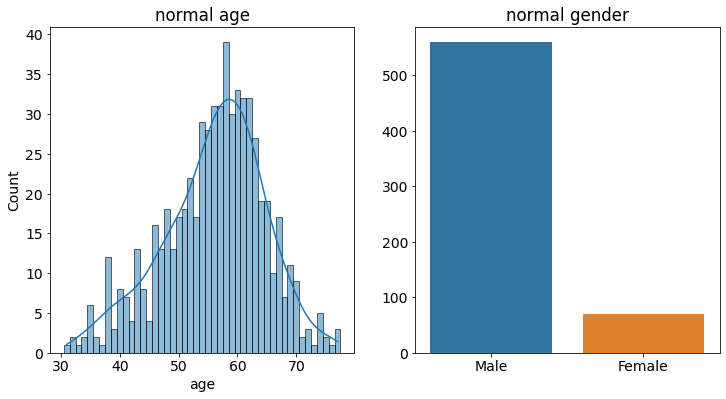

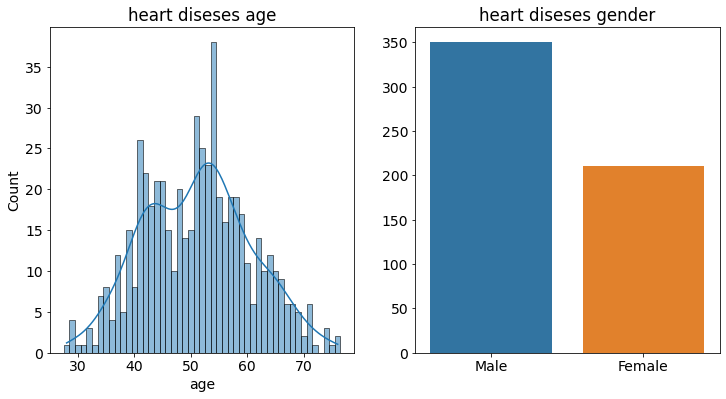

In [3]:
###############################################################################
## TODO: Find the shape of the dataset.                                      ##
###############################################################################
shape = df.shape
print("shape of dataset is: " , shape)

###############################################################################
## TODO: Check if there is missing entries in the dataset columnwise.        ##
###############################################################################
missings = df.isnull()
if sum(missings.sum()) == 0:
  print("this dataset has not missing value")
else:
  print("this dataset has missing value")

###############################################################################
## TODO: Check whether the dataset is balanced or not.                       ##
## If the difference between 2 classes was less than 100 for our dataset,    ##
## it is called "ballanced".                                                 ##
###############################################################################
target = df['target']

if abs(len(target) - 2 * target.sum()) < 100:
  print("ballanced: True")
else:
  print("ballanced: False")

###############################################################################
## TODO: plot the age distirbution and gender distrbution for both normal    ##
## and heart diseses patients.(4 plots)                                      ##
###############################################################################
print('-'*45, "Plots", '-'*45)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size':14})

normal_age = df[df['target'] == 1]['age']
normal_gender = df[df['target'] == 1]['sex']
heart_diseses_age = df[df['target'] == 0]['age']
heart_diseses_gender = df[df['target'] == 0]['sex']


plt.figure()

plt.subplot(1, 2, 1)
sns.histplot(normal_age, binwidth=1, discrete=True, kde=True);
plt.title('normal age')

plt.subplot(1, 2, 2)
sns.barplot(x=['Male', 'Female'], y=[normal_gender.sum(), len(normal_gender) - normal_gender.sum()]);
plt.title('normal gender')

plt.figure()

plt.subplot(1, 2, 1)
sns.histplot(heart_diseses_age, binwidth=1, discrete=True, kde=True);
plt.title('heart diseses age')

plt.subplot(1, 2, 2)
sns.barplot(x=['Male', 'Female'], y=[heart_diseses_gender.sum(), len(heart_diseses_gender) - heart_diseses_gender.sum()]);
plt.title('heart diseses gender')

plt.show()

In [ ]:
fem_n = (len(normal_gender)-normal_gender.sum(), len(heart_diseses_gender)-heart_diseses_gender.sum())
fem_p = fem_n[1] / (fem_n[0] + fem_n[1])
print(fem_n, fem_p)

men_n = (normal_gender.sum(), heart_diseses_gender.sum())
men_p = men_n[1] / (men_n[0] + men_n[1])
print(men_n, men_p)

(70, 211) 0.7508896797153025
(559, 350) 0.385038503850385



#### Question 1: What do you conclude from the plots?
#### Answer:

The probability of suffering from heart risk in women is about $0.75\%$ and in men is $0.38\%$. Therefore, suffering from heart risk is more commen in women.

Also we can figure out suffering from heart risk is higher at the age of 40 to 45 and 50 to 60 years, with the highest probability at $\approx$55.

#### Outlier Detection & Removal:
We will filter outliers using Z-test.

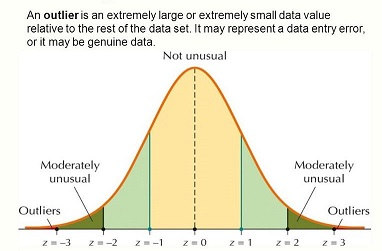

Z-test formula:
\begin{equation*}
    Z = \bigg|\frac {x - mu} {std}\bigg|
\end{equation*}

In [4]:
################################################################################
## TODO: Suppose that, based on our prior knowledge, we know some columns have##
## outliers. Calculate z-score for each featuer and determine the outliers    ##
## with threshold=3, then eliminate them. Target dataframe has(1173,12)shape. ##
################################################################################
columns = ["age","resting bp s","cholesterol","max heart rate"]
threshold = 3


for col in columns:
  col_value = df[col]
  Z = (col_value - col_value.mean()) / col_value.std()
  df = df[abs(Z) <= threshold]

print(df.shape)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

(1173, 12)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.


In [5]:
################################################################################
## TODO: Normalize numerical features to be between 0 and 1                   ##
## Note that just numerical fetures should be normalized. type of features is ##
## determined in dataset description file.                                    ##
################################################################################

numerical_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

for col in numerical_columns:
  col_value = df[col]
  max_value = col_value.max()
  min_value = col_value.min()
  df[col] = (col_value - min_value) / (max_value - min_value)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

### SVM - (60 pts)

#### spliting data

In [6]:
# The original dataset labels is 0 and 1 and in the following code we change it to -1 and 1. 
df.target.replace(0 , -1 , inplace = True) 

# Turn pandas dataframe to numpy array type
df = df.to_numpy()

# Splitting data into train and test part. 70% for train and 30% for test
train = df[:int(len(df) * 0.7)]
test = df[int(len(df) * 0.7):]

# Getting features 
X_train = train[: , :-1]
X_test = test[: , :-1]

# Getting labels
y_train = train[: , -1]
y_test = test[: , -1]

# shapes should be: 
# Train: (821, 11) (821,)
# Test: (352, 11) (352,)
print("Train: ", X_train.shape ,y_train.shape)
print("Test: " ,X_test.shape ,y_test.shape)


Train:  (821, 11) (821,)
Test:  (352, 11) (352,)


#### SVM Using sklearn:
Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) RBF. You can change C to achive better results. For "RBF" find "gamma" witch takes 90% accuracy, at least. For polynomial kernel you are allowed to change "degree" to find best results.

For each kernel, reportting the followings is required:
Accuracy, Precision, Recall, F1score.

In [7]:
def classification_report(y_true, y_pred):
    #################################################################################
    ## TODO: Define a function that returns the followings:                        ##
    ## Accuracy, Precision, Recall, F1score.                                       ##
    #################################################################################

    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == -1) & (y_pred == -1)).sum()
    FP = ((y_true == -1) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == -1)).sum()

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1score = 2 * Precision * Recall / (Precision + Recall)

    #################################################################################
    #                                 END OF YOUR CODE                              #
    #################################################################################
    return Accuracy, Precision, Recall, F1score

In [23]:
#########################################################################################
## TODO: Use svm of sklearn package (imported above) with 3 kernels.                   ##
## You should define model, fit using X_train, predict using X_test.                   ##
## your predictions known as y_pred.                                                   ##
## then use classification_report function to evaluate model.                          ##
#########################################################################################

# linear kernel

svclassifier = SVC(C=1, kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of sklearn svm linear kernel:", classification_report(y_test, y_pred))



# polynomial kernel

svclassifier = SVC(kernel='poly', degree=5, gamma=50)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of sklearn svm polynomial kernel:", classification_report(y_test, y_pred))



# rbf kernel

svclassifier = SVC(C=10, kernel='rbf', gamma=5)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of sklearn svm RBF kernel:", classification_report(y_test, y_pred))


#########################################################################################
#                                      END OF YOUR CODE                                 #
#########################################################################################

results of sklearn svm linear kernel: (0.7869318181818182, 0.7756410256410257, 0.7515527950310559, 0.7634069400630915)
results of sklearn svm polynomial kernel: (0.8948863636363636, 0.8924050632911392, 0.8757763975155279, 0.8840125391849529)
results of sklearn svm RBF kernel: (0.9119318181818182, 0.90625, 0.9006211180124224, 0.9034267912772586)


#### SVM:
Now that you know how the standard library SVM works on the dataset, attempt to implement your own version of SVM. Implement SVM using Quadratic Programming(QP) approach. Remember that SVM objective fuction with QP is:

\begin{equation*}
    min_{\alpha}\quad\frac{1}{2}\alpha^T\,Q\,\alpha-1^T\,\alpha\\
    s.t.\qquad y^T\,\alpha=0,\,\alpha\ge0
\end{equation*}

where:
\begin{equation*}
    Q_{i,j}=y_i\,y_j\,\langle x_i\,,\,x_j\rangle
\end{equation*}

and:
\begin{equation*}
    \text{if}\;(\alpha_n>0)\;\text{then}\;x_n\;\text{is a  support vector}
\end{equation*}

For this perpose, complete the following code. You are allowed to use "cvxopt" package. It's an optimization package for Quadratic Programming. Below is the user's guide for the QP from CVXOPT:

[Quadratic Programming](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)

In [34]:
# Hide cvxopt output
cvxopt.solvers.options["show_progress"] = False

#####################################################################################
## TODO: Use the information from the lecture slides to formulate the SVM          ##
## kernels. These kernel functions will be called in the SVM class.                ##
#####################################################################################

def linear_kernel(X, Y):
    return np.dot(X, Y)

def polynomial_kernel(X, Y, degree=3, coef=1e-10):
    return (coef + X.dot(Y)) ** degree

def rbf_kernel(X, Y, gamma=5):
    return np.exp(-gamma * np.linalg.norm(X - Y) ** 2)

#####################################################################################
#                                   END OF YOUR CODE                                #
#####################################################################################


class MySVM(object):
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):

        n_samples, n_features = X.shape

        #####################################################################################
        ## TODO: Compute Gram matrix "K" for the given kernel.                             ##
        #####################################################################################        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################


        #####################################################################################
        ## TODO: Setup SVM objective function in QP form (Notation from attached link).    ##
        ## Guidance: G and h have defferent definition if C is used or not.                ##
        #####################################################################################
        # P = cvxopt.matrix(np.outer(y, y) * K)
        # q = cvxopt.matrix(-1 * np.ones(n_samples))

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones((n_samples, 1)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(-np.eye(n_samples))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G = cvxopt.matrix(np.vstack((-np.identity(n_samples), np.identity(n_samples))))
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        alpha = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = alpha > 1e-5

        #this will actually give the indices of the support vectors
        ind = np.arange(len(alpha))[sv]

        # get alphas of support vector , Xs and ys too.
        # print('alpha[sv] =', alpha[sv])
        self.alpha = alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        #####################################################################################
        ## TODO: Compute the Intercept b and Weight vector w.                              ##
        #####################################################################################
        # Intercept
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alpha * self.sv_y * K[ind[n], sv])
        self.b /= len(self.alpha)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.alpha)):
                self.w += self.alpha[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None #Guidance: for non-linear case this should be None. (do not change)
        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################

    def predict(self, X):
        if self.w is not None:
            return np.sign(np.dot(X, self.w) + self.b)
        else:
        #####################################################################################
        ## TODO: For non-linear case, implement the kernel trick to predict the label.     ##
        #####################################################################################
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return np.sign(y_predict + self.b)

        #####################################################################################
        #                                   END OF YOUR CODE                                #
        #####################################################################################

In [35]:
###################################################################################
## TODO: define 3 model same as previous part (SVM Using sklearn) and evaluate   ##
## them. Note that for comaparing your result with that part for each kernel use ##
## same parameters in both parts.                                                ##
###################################################################################

# linear kernel

svclassifier = MySVM(C=1, kernel=linear_kernel)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of MySVM linear kernel:", classification_report(y_test , y_pred))


# polynomial kernel

svclassifier = MySVM(kernel=polynomial_kernel)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of MySVM polynomial kernel:", classification_report(y_test , y_pred))


# rbf kernel

svclassifier = MySVM(kernel=rbf_kernel)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of Mysvm RBF kernel:", classification_report(y_test , y_pred))

results of MySVM linear kernel: (0.7926136363636364, 0.7972972972972973, 0.7329192546583851, 0.7637540453074434)
results of MySVM polynomial kernel: (0.8892045454545454, 0.88125, 0.8757763975155279, 0.8785046728971962)
results of Mysvm RBF kernel: (0.90625, 0.9, 0.8944099378881988, 0.897196261682243)


#### Question 2: Report best results.



1.  Best kernel: rbf
2.  Best Accuracy: 93.18%




In [39]:
svclassifier = SVC(C=50, kernel='rbf', gamma=20)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of sklearn svm RBF kernel:", classification_report(y_test, y_pred))

results of sklearn svm RBF kernel: (0.9318181818181818, 0.9101796407185628, 0.9440993788819876, 0.9268292682926829)


### Bonus Score - (10pts)

In this step you can check other kernel functions or change parameters or any idea to get better result in compare with last section's results.

In [97]:
def my_kernel(X, Y):
  return np.exp(-15 * np.linalg.norm(X - Y) ** 2) * np.exp(- np.linalg.norm(X - Y))

# precomputed kernel

svclassifier = MySVM(kernel=my_kernel)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("results of sklearn svm precomputed kernel:", classification_report(y_test, y_pred))

results of sklearn svm precomputed kernel: (0.9403409090909091, 0.926829268292683, 0.9440993788819876, 0.9353846153846155)
